# Non-coronagraphic angular differential imaging

In this tutorial, we will process and analyze an archival [SPHERE/ZIMPOL](https://www.eso.org/sci/facilities/paranal/instruments/sphere/inst.html) dataset of [HD 142527](https://ui.adsabs.harvard.edu/abs/2019A%26A...622A.156C/abstract) that was obtained with the narrowband H$\alpha$ filter (*N_Ha*) and without coronagraph. A few ZIMPOL specific preprocessing steps were already done so we start the processing of the data with the bad pixel cleaning and image registration. There are pipeline modules available for dual-band simultaneous differential imaging (i.e. [SDIpreparationModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.psfpreparation.SDIpreparationModule) and [SubtractImagesModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.basic.SubtractImagesModule)) but for simplicity we only use the *N_Ha* data in this tutorial in combination with angular differential imaging.

## Getting started

Let's start by importing the required Python modules. 

In [1]:
import configparser
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

And also the pipeline and required modules of PynPoint.

In [2]:
from pynpoint import Pypeline, FitsReadingModule, ParangReadingModule, \
                     StarExtractionModule, BadPixelSigmaFilterModule, \
                     StarAlignmentModule, FitCenterModule, ShiftImagesModule, \
                     PSFpreparationModule, PcaPsfSubtractionModule, \
                     FalsePositiveModule, SimplexMinimizationModule, \
                     FakePlanetModule, ContrastCurveModule, \
                     FitsWritingModule, TextWritingModule

Next, we will download a tarball with the preprocessed images and the parallactic angles.

In [3]:
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/pynpoint/hd142527_zimpol_h-alpha.tgz',
                           'hd142527_zimpol_h-alpha.tgz')

('hd142527_zimpol_h-alpha.tgz', <http.client.HTTPMessage at 0x1454433d0>)

Will unpack the compressed archive file in a folder called *input*.

In [4]:
tar = tarfile.open('hd142527_zimpol_h-alpha.tgz')
tar.extractall(path='input')

## Creating the configuration file

PynPoint requires a configuration file with the global settings and the FITS header keywords that have to be imported. The text file should be named `PynPoint_config.ini` (see [documentation](https://pynpoint.readthedocs.io/en/latest/configuration.html) for several instrument specific examples) and located in the working place of the pipeline.

In this case, we don't need any of the header data but we set the pixel scale to 3.6 mas pixel$^{-1}$ with the `PIXSCALE` keyword. We also set the `MEMORY` keyword to `None` such that that all images of a dataset are loaded at once in the RAM when the data is processed by a certain pipeline module. The number of processes that is used by pipeline modules that support multiprocessing (see [overview of pipeline modules](https://pynpoint.readthedocs.io/en/latest/overview.html)) is set with the `CPU` keyword.

In [5]:
config = configparser.ConfigParser()
config.add_section('header')
config.add_section('settings')
config['settings']['PIXSCALE'] = '0.0036'
config['settings']['MEMORY'] = 'None'
config['settings']['CPU'] = '1'

with open('PynPoint_config.ini', 'w') as configfile:
    config.write(configfile)

## Initiating the Pypeline

We can now initiate the `Pypeline` by setting the working, input, and output folders. The configuration file will be read and the HDF5 database is created in the working place since it does not yet exist.

In [6]:
pipeline = Pypeline(working_place_in='./',
                    input_place_in='input/',
                    output_place_in='./')

PynPoint v0.9.0

Working place: ./
Input place: input/
Output place: ./

Database: ./PynPoint_database.hdf5
Configuration: ./PynPoint_config.ini

Number of CPUs: 1
Number of threads: not set


Some routines by libraries such as `numpy` and `scipy` use multithreading. The number of threads can be set beforehand from the command line with the `OMP_NUM_THREADS` environment variable (e.g. `export OMP_NUM_THREADS=4`). This is in particular important if a pipeline module also uses multiprocessing.

## Importing the images and parallactic angles

We will now import the images from the FITS files into the PynPoint database. This is done by first adding an instance of the [FitsReadingModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.readwrite.html#pynpoint.readwrite.fitsreading.FitsReadingModule) to the `Pypeline` with the `add_module` method and then running the module with the `run_module` method. The data is stored in the database with the name of the `image_tag` argument.

In [7]:
module = FitsReadingModule(name_in='read',
                           input_dir=None,
                           image_tag='zimpol',
                           overwrite=True,
                           check=False,
                           filenames=None,
                           ifs_data=False)

pipeline.add_module(module)
pipeline.run_module('read')


-----------------
FitsReadingModule
-----------------

Module name: read
Reading FITS files... [DONE]                      
Output ports: zimpol (70, 1024, 1024), fits_header/cal_OBS091_0235_cam2.fits (868,), fits_header/cal_OBS091_0237_cam2.fits (868,), fits_header/cal_OBS091_0239_cam2.fits (868,), fits_header/cal_OBS091_0241_cam2.fits (868,), fits_header/cal_OBS091_0243_cam2.fits (868,), fits_header/cal_OBS091_0245_cam2.fits (868,), fits_header/cal_OBS091_0247_cam2.fits (868,)


Let's check the shape of the imported dataset. There are 70 images of 1024 by 1024 pixels.

In [8]:
pipeline.get_shape('zimpol')

(70, 1024, 1024)

We will also import the parallactic angles from a plain text file (a FITS file would also work) by using the [ParangReadingModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.readwrite.html#pynpoint.readwrite.attr_reading.ParangReadingModule). The angles will be stored as the `PARANG` attribute to the dataset that was previously imported and has the database tag *zimpol*.

In [9]:
module = ParangReadingModule(name_in='parang',
                             data_tag='zimpol',
                             file_name='parang.dat',
                             input_dir=None,
                             overwrite=True)

pipeline.add_module(module)
pipeline.run_module('parang')


-------------------
ParangReadingModule
-------------------

Module name: parang
Reading parallactic angles... [DONE]
Number of angles: 70
Rotation range: -14.31 - 34.36 deg
Output port: zimpol (70, 1024, 1024)


The attributes can be read from the database with the [get_attribute](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=get_data#pynpoint.core.pypeline.Pypeline.get_attribute) method of the `Pypeline`. Let's have a look at the values of `PARANG`.

In [10]:
pipeline.get_attribute('zimpol', 'PARANG', static=False)

array([-14.3082 , -13.9496 , -13.5902 , -13.23   , -12.8691 , -12.5074 ,
       -12.145  , -11.782  , -11.4182 , -11.0538 ,  -6.43366,  -6.0622 ,
        -5.69037,  -5.3182 ,  -4.9457 ,  -4.57291,  -4.19983,  -3.8265 ,
        -3.45294,  -3.07917,   1.61837,   1.99275,   2.36701,   2.74112,
         3.11507,   3.48882,   3.86237,   4.23567,   4.60872,   4.98149,
         9.6373 ,  10.0041 ,  10.3703 ,  10.736  ,  11.101  ,  11.4653 ,
        11.829  ,  12.192  ,  12.5543 ,  12.9158 ,  17.3717 ,  17.7218 ,
        18.0711 ,  18.4193 ,  18.7666 ,  19.1129 ,  19.4581 ,  19.8024 ,
        20.1456 ,  20.4878 ,  24.9167 ,  25.243  ,  25.568  ,  25.8919 ,
        26.2145 ,  26.536  ,  26.8563 ,  27.1753 ,  27.4931 ,  27.8097 ,
        31.7057 ,  32.0052 ,  32.3035 ,  32.6005 ,  32.8962 ,  33.1906 ,
        33.4838 ,  33.7757 ,  34.0663 ,  34.3556 ])

## Bad pixel correction

The first processing module that we will use is the [BadPixelSigmaFilterModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.badpixel.BadPixelSigmaFilterModule) to correct bad pixels with a sigma filter. We replace outliers that deviate by more than 3$\sigma$ from their neighboring pixels and iterate three times. 

The input port of `image_in_tag` points to the dataset that was imported by the `FitsReadingModule` and the output port of `image_out_tag` stores the processed / cleaned dataset in the database.

In [11]:
module = BadPixelSigmaFilterModule(name_in='badpixel',
                                   image_in_tag='zimpol',
                                   image_out_tag='bad',
                                   map_out_tag=None,
                                   box=9,
                                   sigma=3.,
                                   iterate=3)

pipeline.add_module(module)
pipeline.run_module('badpixel')


-------------------------
BadPixelSigmaFilterModule
-------------------------

Module name: badpixel
Input port: zimpol (70, 1024, 1024)
Bad pixel sigma filter... [DONE]                      
Output port: bad (70, 1024, 1024)


## Image centering

Next, we will crop the image around the brightest pixel at the position of the star with the [StarExtractionModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.extract.StarExtractionModule).

In [12]:
module = StarExtractionModule(name_in='extract',
                              image_in_tag='bad',
                              image_out_tag='crop',
                              index_out_tag=None,
                              image_size=0.2,
                              fwhm_star=0.03,
                              position=(476, 436, 0.1))

pipeline.add_module(module)
pipeline.run_module('extract')


--------------------
StarExtractionModule
--------------------

Module name: extract
Input port: bad (70, 1024, 1024)
Extracting stellar position... [DONE]                      
Output port: crop (70, 57, 57)


Let's have a look at the first image from the processed data that is now centered with pixel precision. The data van be read from the database by using the [get_data](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=get_data#pynpoint.core.pypeline.Pypeline.get_data) method of the `Pypeline`.

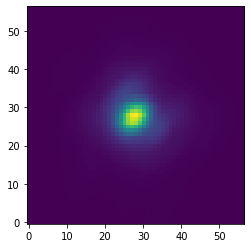

In [13]:
data = pipeline.get_data('crop')
plt.imshow(data[0, ], origin='lower')

After the approximate centering, we apply a relative alignment of the images with the [StarAlignmentModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.centering.StarAlignmentModule) by cross-correlating each images with 10 randomly selected images from the dataset. Each image is then shifted to the average offset from the cross-correlation with the 10 images.

In [14]:
module = StarAlignmentModule(name_in='align',
                             image_in_tag='crop',
                             ref_image_in_tag=None,
                             image_out_tag='aligned',
                             interpolation='spline',
                             accuracy=10,
                             resize=None,
                             num_references=10,
                             subframe=0.1)

pipeline.add_module(module)
pipeline.run_module('align')


-------------------
StarAlignmentModule
-------------------

Module name: align
Input port: crop (70, 57, 57)
Aligning images... [DONE]                      
Output port: aligned (70, 57, 57)


As a third centering step, we use the [FitCenterModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.centering.FitCenterModule) to fit the PSF of the mean image with a 2D Moffat function. The best-fit parameters are stored in the database at the argument name of `fit_out_tag`.

In [15]:
module = FitCenterModule(name_in='center',
                         image_in_tag='aligned',
                         fit_out_tag='fit',
                         mask_out_tag=None,
                         method='mean',
                         radius=0.1,
                         sign='positive',
                         model='moffat',
                         filter_size=None,
                         guess=(0., 0., 10., 10., 10000., 0., 0., 1.))

pipeline.add_module(module)
pipeline.run_module('center')


---------------
FitCenterModule
---------------

Module name: center
Input port: aligned (70, 57, 57)
Fitting the stellar PSF... [DONE]
Output port: fit (70, 16)


The processed images from the `StarAlignmentModule` and the best-fit parameters from the `FitCenterModule` are now used as input for [ShiftImagesModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.centering.ShiftImagesModule). This module shifts all images by the (constant) offset such that the peak of the Moffat function is located in the center of the image.

In [16]:
module = ShiftImagesModule(name_in='shift',
                           image_in_tag='aligned',
                           image_out_tag='centered',
                           shift_xy='fit',
                           interpolation='spline')

pipeline.add_module(module)
pipeline.run_module('shift')


-----------------
ShiftImagesModule
-----------------

Module name: shift
Input ports: aligned (70, 57, 57), fit (70, 16)
Shifting the images... [DONE]                      
Output port: centered (70, 57, 57)


Let's have a look at the central part of the first image. The brightest pixel of the PSF is indeed in the center of the image as expected.

(17.0, 40.0)

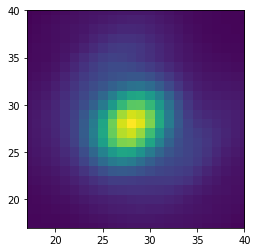

In [17]:
data = pipeline.get_data('centered')
plt.imshow(data[0, ], origin='lower')
plt.xlim(17, 40)
plt.ylim(17, 40)

## Masking the images

Before running the PSF subtraction, we use the [PSFpreparationModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.psfpreparation.PSFpreparationModule) to mask the central part of the PSF and we also create a outer mask with a diameter equal to the field of view of the image. The latter is achieved by simply setting the argument of `edge_size` to a value that is larger than the field of view.

In [18]:
module = PSFpreparationModule(name_in='prep1',
                              image_in_tag='centered',
                              image_out_tag='prep',
                              mask_out_tag=None,
                              norm=False,
                              cent_size=0.02,
                              edge_size=0.2)

pipeline.add_module(module)
pipeline.run_module('prep1')


--------------------
PSFpreparationModule
--------------------

Module name: prep1
Input port: centered (70, 57, 57)
Preparing images for PSF subtraction... [DONE]                      
Output port: prep (70, 57, 57)


Let's have a look at the first image and show it on a logarithmic color scale.

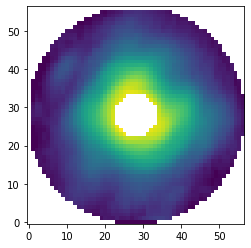

In [19]:
data = pipeline.get_data('prep')
max_flux = np.amax(data[0, ])
plt.imshow(data[0, ], origin='lower', norm=LogNorm(vmin=0.01*max_flux, vmax=max_flux))

Later on, we require a PSF template for both the relative calibration and the estimation of detection limits. Therefore, we create another masked dataset from the centered images but this time we only mask pixels beyond 70 mas and do not use a central mask.

In [20]:
module = PSFpreparationModule(name_in='prep2',
                              image_in_tag='centered',
                              image_out_tag='psf',
                              mask_out_tag=None,
                              norm=False,
                              cent_size=None,
                              edge_size=0.07)

pipeline.add_module(module)
pipeline.run_module('prep2')


--------------------
PSFpreparationModule
--------------------

Module name: prep2
Input port: centered (70, 57, 57)
Preparing images for PSF subtraction... [DONE]                      
Output port: psf (70, 57, 57)


Let's have a look at the first image from this stack of PSF templates.

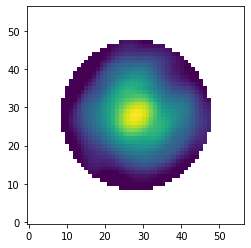

In [21]:
data = pipeline.get_data('psf')
max_flux = np.amax(data[0, ])
plt.imshow(data[0, ], origin='lower', norm=LogNorm(vmin=0.01*max_flux, vmax=max_flux))

## PSF subtraction with PCA

After masking the images, we will now run the PSF subtraction with an implementation of full-frame PCA. We use the [PcaPsfSubtractionModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.psfsubtraction.PcaPsfSubtractionModule) and set the argument of `pca_numbers` to a range from 1 to 30 principal components. This means that the mean- and median-collapsed residuals that are stored with the output ports to `res_mean_tag` and `res_median_tag` will contain 30 images, so with an increasing number of subtracted principal components. We will also store the PCA basis (i.e. the principal components) and apply an extra rotation of -133 deg such that north will be aligned with the positive *y* axis.

In [22]:
module = PcaPsfSubtractionModule(name_in='pca',
                                 images_in_tag='prep',
                                 reference_in_tag='prep',
                                 res_mean_tag='pca_mean',
                                 res_median_tag='pca_median',
                                 basis_out_tag='pca_basis',
                                 pca_numbers=range(1, 31),
                                 extra_rot=-133.,
                                 subtract_mean=True,
                                 processing_type='ADI')

pipeline.add_module(module)
pipeline.run_module('pca')


-----------------------
PcaPsfSubtractionModule
-----------------------

Module name: pca
Input port: prep (70, 57, 57)
Input parameters:
   - Post-processing type: ADI
   - Number of principal components: range(1, 31)
   - Subtract mean: True
   - Extra rotation (deg): -133.0
Constructing PSF model... [DONE]
Output ports: pca_mean (30, 57, 57), pca_median (30, 57, 57), pca_basis (30, 57, 57)


Let's have a look and the median-collapsed residuals after subtracting 15 principal components. The H$\alpha$ emission from the accreting M dwarf companion HD 142527 B is clearly detected east / left of the central star.

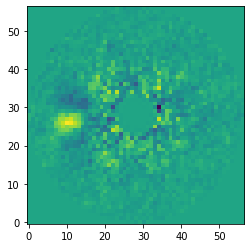

In [23]:
data = pipeline.get_data('pca_median')
plt.imshow(data[14, ], origin='lower')

Let's also have a look at the PCA basis that was stored at the *pca_basis* tag. Here we plot the second principal component.

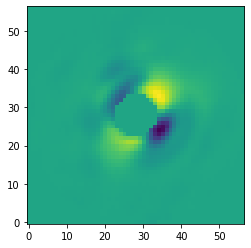

In [24]:
data = pipeline.get_data('pca_basis')
plt.imshow(data[1, ], origin='lower')

## Signal-to-noise and false positive fraction

Now that we have the residuals of the PSF subtraction, we can calculate the signal-to-noise ratio (S/N) and false positive fraction (FPF) of the detected signal as function of number of principal components that have been subtracted.

To do so, we will first check at which pixel coordinates the aperture should be placed such that it encompasses most of the companion flux while excluding most of the (negative) self-subtraction regions. We will read the median-collapsed residuals with the `get_data` method.

In [25]:
data = pipeline.get_data('pca_median')

And we use the functionalities of `matplotlib` to overlay an aperture on the residuals after subtracting 15 principal components.

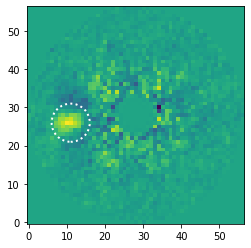

In [26]:
fig, ax = plt.subplots()
ax.imshow(data[14, ], origin='lower')
aperture = Circle((11, 26), radius=5, fill=False, ls=':', lw=2., color='white')
ax.add_artist(aperture)

Next, we use the [FalsePositiveModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.fluxposition.FalsePositiveModule) to calculate both the S/N and FPF. We set position of the `aperture` to the coordinates that we tested and the radius of the aperture to 5 pixels. For the reference apertures, we will ignore the neighboring apertures to the companion (i.e. `ignore=True`) such that the self-subtraction regions will not bias the noise estimate.

In [27]:
module = FalsePositiveModule(name_in='snr',
                             image_in_tag='pca_median',
                             snr_out_tag='snr',
                             position=(11., 26.),
                             aperture=5.*0.0036,
                             ignore=True,
                             optimize=False)

pipeline.add_module(module)
pipeline.run_module('snr')


-------------------
FalsePositiveModule
-------------------

Module name: snr
Input port: pca_median (30, 57, 57)
Input parameters:
   - Aperture position = (11.0, 26.0)
   - Aperture radius (pixels) = 5.00
   - Optimize aperture position = False
   - Ignore neighboring apertures = True
   - Minimization tolerance = 0.01
Calculating the S/N and FPF...
Image 001/30 -> (x, y) = (11.00, 26.00), S/N = 5.54, FPF = 7.28e-04
Image 002/30 -> (x, y) = (11.00, 26.00), S/N = 4.85, FPF = 1.43e-03
Image 003/30 -> (x, y) = (11.00, 26.00), S/N = 5.75, FPF = 6.01e-04
Image 004/30 -> (x, y) = (11.00, 26.00), S/N = 7.43, FPF = 1.53e-04
Image 005/30 -> (x, y) = (11.00, 26.00), S/N = 10.16, FPF = 2.64e-05
Image 006/30 -> (x, y) = (11.00, 26.00), S/N = 8.92, FPF = 5.54e-05
Image 007/30 -> (x, y) = (11.00, 26.00), S/N = 8.35, FPF = 8.02e-05
Image 008/30 -> (x, y) = (11.00, 26.00), S/N = 5.59, FPF = 6.99e-04
Image 009/30 -> (x, y) = (11.00, 26.00), S/N = 7.81, FPF = 1.16e-04
Image 010/30 -> (x, y) = (11.00,

The results have been stored in the dataset with the tag *snr*. Let's plot the S/N as function of principal components that have been extracted. As expected, for a large number of components the S/N goes towards zero due to increased self-subtraction.

Text(0, 0.5, 'Signal-to-noise ratio')

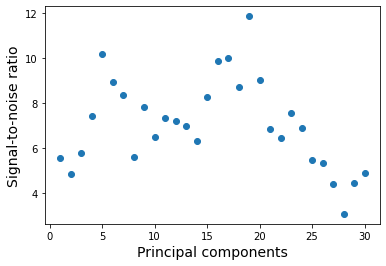

In [28]:
data = pipeline.get_data('snr')
plt.plot(range(1, 31), data[:, 4], 'o')
plt.xlabel('Principal components', fontsize=14)
plt.ylabel('Signal-to-noise ratio', fontsize=14)

## Relative photometric and astrometric calibration

With the next analysis, we will measure the relative brightness and position of the companion. We will use the [SimplexMinimizationModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.fluxposition.SimplexMinimizationModule) to minimize the flux within a large aperture at the position of the companion while iterative injecting negative copies of the PSF. This procedure will be repeated for principal components in the range of 1 to 10. We need to specify two database tags as input, namely the stack of centered images and the PSF templates (i.e. the stack of masked images) that will be injected to remove the companion flux. Apart from an approximate position of the companion, the downhill simplex method of the minimization algorithm also requires an estimate (e.g. within ${\sim} 1$ magnitude from the actual value) of the flux contrast.

In [29]:
module = SimplexMinimizationModule(name_in='simplex',
                                   image_in_tag='centered',
                                   psf_in_tag='psf',
                                   res_out_tag='simplex',
                                   flux_position_tag='fluxpos',
                                   position=(11, 26),
                                   magnitude=6.,
                                   psf_scaling=-1.,
                                   merit='gaussian',
                                   aperture=10.*0.0036,
                                   sigma=0.,
                                   tolerance=0.01,
                                   pca_number=range(1, 11),
                                   cent_size=0.02,
                                   edge_size=0.2,
                                   extra_rot=-133.,
                                   residuals='median',
                                   reference_in_tag=None,
                                   offset=None)

pipeline.add_module(module)
pipeline.run_module('simplex')


-------------------------
SimplexMinimizationModule
-------------------------

Module name: simplex
Input ports: centered (70, 57, 57), psf (70, 57, 57)
Input parameters:
   - Number of principal components = range(1, 11)
   - Figure of merit = gaussian
   - Residuals type = median
   - Absolute tolerance (pixels/mag) = 0.01
   - Maximum offset = None
   - Guessed position (x, y) = (11.00, 26.00)
   - Aperture position (x, y) = (11, 26)
   - Aperture radius (pixels) = 10
   - Inner mask radius (pixels) = 5
   - Outer mask radius (pixels) = 55
Image center (y, x) = (28.0, 28.0)
Simplex minimization... 1 PC - chi^2 = 3.64e+02 [DONE]
Best-fit parameters:
   - Position (x, y) = (12.91, 26.00)
   - Separation (mas) = 54.81
   - Position angle (deg) = 97.56
   - Contrast (mag) = 5.69
Simplex minimization... 2 PC - chi^2 = 1.87e+02 [DONE]
Best-fit parameters:
   - Position (x, y) = (13.49, 26.75)
   - Separation (mas) = 52.42
   - Position angle (deg) = 94.92
   - Contrast (mag) = 5.45
Simpl

When running the `SimplexMinimizationModule`, we see the $\chi^2$ value changing until the tolerance threshold has been reached. The best-fit position and contrast is then printed and also stored in the database at the `flux_position_tag`. If the argument of `pca_number` is a list or range (instead of a single value), then the names of the `flux_position_tag` and `res_out_tag` are appended with the number of principal components in 3 digits (e.g. 003 for 3 principal components).

The `res_out_tag` contains the PSF subtraction residuals for each iteration so the last image in the dataset shows the best-fit result. Let's have a look at the residuals after subtracting 10 principal components with the best-fit negative PSF injected (i.e. which has fully cancelled the companion flux).

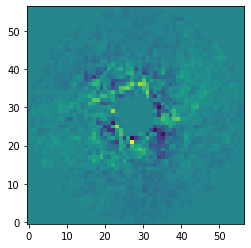

In [30]:
data = pipeline.get_data('simplex010')
plt.imshow(data[-1, ], origin='lower')

Let's also plot the measured separation, position angle, and contrast as function of principal components that have been subtracted.

Text(0, 0.5, 'Contrast (mag)')

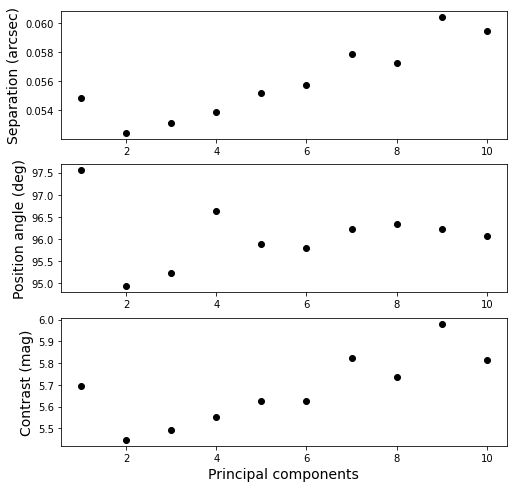

In [31]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

for i in range(1, 11):
    data = pipeline.get_data(f'fluxpos{i:03d}')
    ax1.scatter(i, data[-1, 2], color='black')
    ax2.scatter(i, data[-1, 3], color='black')
    ax3.scatter(i, data[-1, 4], color='black')

ax3.set_xlabel('Principal components', fontsize=14)
ax1.set_ylabel('Separation (arcsec)', fontsize=14)
ax2.set_ylabel('Position angle (deg)', fontsize=14)
ax3.set_ylabel('Contrast (mag)', fontsize=14)

## Detection limits

As a final analysis, we will estimate detection limits from the data. To do so, we will first use the [FakePlanetModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.fluxposition.FakePlanetModule) to remove the flux of the companion from the data since it would otherwise bias the result. We use the PSF template that was stored with the tag *psf* and we adopt the separation and position angle that was determined with the `SimplexMinimizationModule`. We need to apply a correction of -133 degrees which was used previously for `extra_rot`.

In [32]:
module = FakePlanetModule(name_in='fake',
                          image_in_tag='centered',
                          psf_in_tag='psf',
                          image_out_tag='removed',
                          position=(0.061, 97.3-133.),
                          magnitude=6.1,
                          psf_scaling=-1.,
                          interpolation='spline')

pipeline.add_module(module)
pipeline.run_module('fake')


----------------
FakePlanetModule
----------------

Module name: fake
Input ports: centered (70, 57, 57), psf (70, 57, 57)
Input parameters:
   - Magnitude = 6.10
   - PSF scaling = -1.0
   - Separation (arcsec) = 0.06
   - Position angle (deg) = 0.06
Injecting artificial planets... [DONE]                      
Output port: removed (70, 57, 57)


Now that the data only contains the flux of the central star, we use the [ContrastCurveModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html#pynpoint.processing.limits.ContrastCurveModule) to calculate the detection limits. We will calculate the brightness limits by setting the false positive fraction (FPF) to $2.87 \times 10^{-7}$, which corresponds to $5\sigma$ in the limit of Gaussian noise. At small angular separations, the detection limits are affected by small sample statistics (see [Mawet et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract)) so this FPF would only correspond to a $5\sigma$ detection at large separation from the star. In this example, we will subtract 10 principal components and use the median-collapsed residuals.

In [33]:
module = ContrastCurveModule(name_in='limits',
                             image_in_tag='removed',
                             psf_in_tag='psf',
                             contrast_out_tag='limits',
                             separation=(0.05, 5., 0.01),
                             angle=(0., 360., 60.),
                             threshold=('fpf', 2.87e-7),
                             psf_scaling=1.,
                             aperture=0.02,
                             pca_number=10,
                             cent_size=0.02,
                             edge_size=2.,
                             extra_rot=-133.,
                             residuals='median',
                             snr_inject=100.)

pipeline.add_module(module)
pipeline.run_module('limits')


-------------------
ContrastCurveModule
-------------------

Module name: limits
Input ports: removed (70, 57, 57), psf (70, 57, 57)
                                                      
Calculating detection limits... [DONE]
Output port: limits (4, 4)


## Exporting datasets to FITS and plain text formats

Now that we have finished the data processing and analysis, we will export some of the results from the HDF5 database to other data formats. Since astronomical images are commonly viewed with tools such as [DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9), we will use the [FitsWritingModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.readwrite.html?highlight=fitswr#pynpoint.readwrite.fitswriting.FitsWritingModule) to write the median-collapsed residuals of the PSF subtraction to a FITS file. The database tag is specified as argument of `data_tag` and we will store the FITS file in the default output place of the `Pypeline`. The FITS file contains a 3D dataset of which the first dimension corresponds to an increasing number of subtracted principal components.

In [34]:
module = FitsWritingModule(name_in='write1',
                           data_tag='pca_median',
                           file_name='pca_median.fits',
                           output_dir=None,
                           data_range=None,
                           overwrite=True,
                           subset_size=None)

pipeline.add_module(module)
pipeline.run_module('write1')


-----------------
FitsWritingModule
-----------------

Module name: write1
Input port: pca_median (30, 57, 57)
Writing FITS file... [DONE]


Similarly, we can export 1D and 2D datasets to a plain text file with the [TextWritingModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.readwrite.html#pynpoint.readwrite.textwriting.TextWritingModule). Let's export the detection limits that were estimated with the `ContrastCurveModule`. We specify again the database tag and also add a header as first line in the text file.

In [35]:
module = TextWritingModule(name_in='write2',
                           data_tag='limits',
                           file_name='limits.dat',
                           output_dir=None,
                           header='Separation (arcsec) - Contrast (mag) - Variance (mag) - FPF')

pipeline.add_module(module)
pipeline.run_module('write2')


-----------------
TextWritingModule
-----------------

Module name: write2
Input port: limits (4, 4)
Writing text file... [DONE]
